# 🚗 Vehicle Counting AI & Traffic Time Calculation

## 🎯 Objective

This script processes a road image to detect and count the number of vehicles using a YOLOv8 object detection model.
Then, it uses this count to calculate a dynamic traffic time ( $Tg$ ) using the formula:

### 🚦 Adaptive Traffic Light Timing Formula

$$
T_g =
\begin{cases}
T_b + k(n_{\text{cars}} - n_{\text{avr}}), & \text{if } n_{\text{cars}} < 2 \cdot n_{\text{avr}} \\
0.7 \cdot [T_b + k(n_{\text{cars}} - n_{\text{avr}})], & \text{if } n_{\text{cars}} \geq 2 \cdot n_{\text{avr}}
\end{cases}
$$

Where:  
- $T_g$: Final green light duration based on real-time traffic  
- $T_b$: Minimum green light time required for safe crossing  
- $k$: Time required for a single vehicle to pass through the intersection  
- $n_{\text{cars}}$: Number of vehicles currently detected  
- $n_{\text{avr}}$: Average number of vehicles typically expected on this road  

**Note:**  
If the detected number of vehicles is **twice or more** than the average expected traffic,  
only **70% of the calculated time** is used. This prevents excessive delays on other roads  
and promotes fair distribution of green time across all directions.



## 🧠 **Technologies Used**

- **YOLOv8**: State-of-the-art object detection algorithm
- **Ultralytics Library**: Simple API for using YOLO models
- **OpenCV**: Image processing
- **Python**: Language of implementation


##  📈 **Workflow** :

* Display image with detected vehicles.
* Show total vehicle count on image.
* Optionally save the annotated image for reporting.




In [ ]:
!pip install ultralytics opencv-python numpy matplotlib

In [ ]:
# 📚 1. Import Required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [ ]:
# 🧠 2. Count Vehicles Function
def count_vehicles(image, model):
    """
    Detects vehicles in a given image using YOLOv8.

    Returns:
    - n_cars: int (number of detected vehicles)
    - results: full detection results object (for visualization)
    """
    results = model(image)[0]

    vehicle_classes = ['car', 'truck', 'bus', 'motorbike']
    n_cars = sum(1 for c in results.boxes.cls if model.names[int(c)] in vehicle_classes)

    return n_cars, results


In [ ]:
# 🧮 3. Compute Tg Function
def calculate_tg(n_cars, Tb, k, n_avr):
    """
    Calculates dynamic green light duration Tg based on detected traffic.

    Logic:
    - If traffic is low or average: Use linear growth
    - If traffic is heavy (≥ 2 × average): Apply 70% cap to limit over-expansion
    """
    base_time = Tb + k * (n_cars - n_avr)

    if n_cars >= 2 * n_avr:
        Tg = 0.7 * base_time
    else:
        Tg = base_time

    return {
        'Tg': round(Tg, 2),
        'Tb': Tb,
        'k': k,
        'n_cars': n_cars,
        'n_avr': n_avr
    }

In [ ]:
# 🎨 4. Visualization Function
def show_results(image, results, n_cars, save_path=None):
    """
    Draw bounding boxes and vehicle count on image.

    Parameters:
    - image: np.ndarray
    - results: YOLO results object
    - n_cars: int
    - save_path: Optional path to save the annotated image
    """
    # Draw predictions on image
    annotated = results.plot()

    # Add vehicle count text
    cv2.putText(annotated, f'Vehicles detected: {n_cars}', (30, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 0), 3)

    # Convert BGR to RGB for matplotlib
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    # Display using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_rgb)
    plt.axis('off')
    plt.title('Detected Vehicles')
    plt.show()

    # Save the result if a path is provided
    if save_path:
        cv2.imwrite(save_path, annotated)
        print(f"✅ Annotated image saved to: {'/content/'}")


In [ ]:

# 🔄 5. Full Pipeline
def process_image(image_path, Tb, k, n_avr, visualize=True, save_result=True):
    """
    Process image and display results with optional visualization and saving.

    Parameters:
    - image_path: str
    - Tb, k, n_avr: calculation parameters
    - visualize: bool, show image
    - save_result: bool, save annotated image

    Returns:
    - dictionary with results
    """
    model = YOLO('yolov8n.pt')
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found: {image_path}")

    n_cars, results = count_vehicles(image, model)
    output = calculate_tg(n_cars, Tb, k, n_avr)

    if visualize:
        save_path = "annotated_traffic.jpg" if save_result else None
        show_results(image, results, n_cars, save_path=save_path)

    return output


0: 448x640 1 person, 14 cars, 1 motorcycle, 1 bus, 2 trucks, 1 stop sign, 284.5ms
Speed: 6.0ms preprocess, 284.5ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


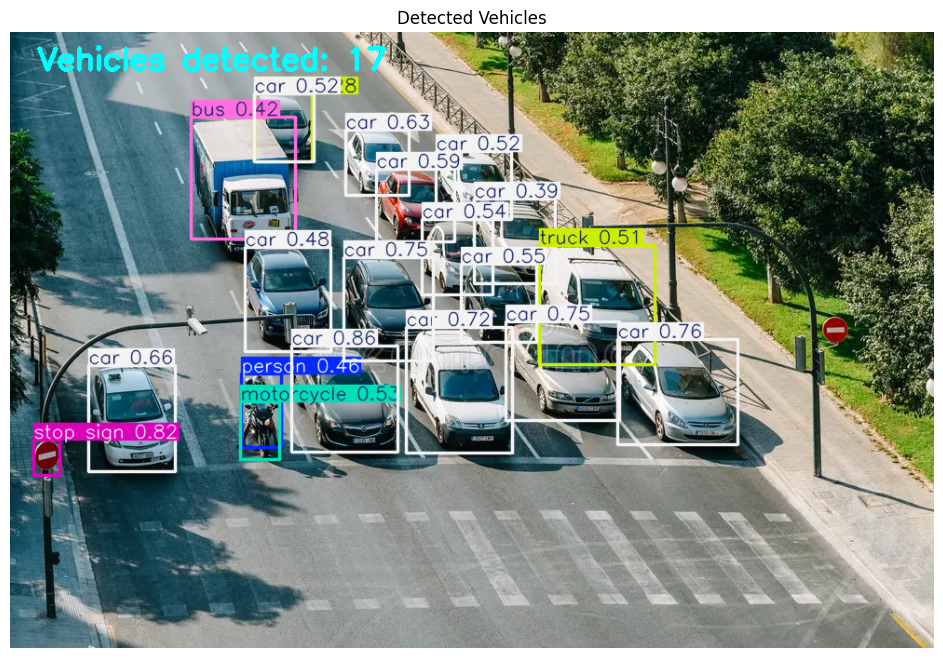

✅ Annotated image saved to: /content/

📊 Final Output:
Tg: 36
Tb: 20
k: 2
n_cars: 17
n_avr: 9


In [ ]:
# 🚀 6. Main Execution Example
if __name__ == "__main__":
    image_path = "/content/traffic.jpg"  # Replace with your actual image
    Tb = 20
    k = 2
    n_avr = 9

    try:
        result = process_image(image_path, Tb, k, n_avr,
                               visualize=True, save_result=True)

        print("\n📊 Final Output:")
        for key, value in result.items():
            print(f"{key}: {value}")

    except Exception as e:
        print(f"❌ Error: {e}")

## 🧠 Reinforcement Learning for Adaptive Traffic Signals

Reinforcement Learning (RL) is an AI technique where an agent learns to make decisions by interacting with an environment and receiving feedback in the form of **rewards**. In the context of traffic control, RL can be used to **learn the optimal green light durations** to minimize total vehicle delay or congestion.

### 🚦 How It Works in Traffic Control

In an RL setup for traffic signals:

- **Agent**: Traffic signal controller (the AI system)
- **Environment**: The intersection and vehicles around it
- **State**: Real-time traffic data (e.g., vehicle counts, queue lengths)
- **Action**: Adjusting the green light duration or choosing which direction to turn green
- **Reward**: Negative vehicle wait time or total delay (i.e., the less the delay, the higher the reward)

> Example: The agent observes that one road is heavily congested and another is empty. It increases the green light time for the congested road. If overall traffic flow improves, it receives a positive reward and reinforces this decision pattern.

### 🧮 RL Training Loop

An RL agent learns through repeated episodes:
1. **Observe** the current traffic state
2. **Select** an action (change green duration)
3. **Receive** feedback (was delay reduced?)
4. **Update** its policy using reward signals

Over time, the agent improves its **policy** — a mapping from traffic states to optimal actions.

---

### ⚠️ Real-Time Limitation

> ⚠️ While RL is powerful for **offline training and simulation**, deploying it in **real-time on live intersections is currently impractical** due to high computational cost, safety concerns, and the need for extensive pre-training with reliable data.

Instead, RL is often used to train policies **offline**, which can then be deployed as fixed models in real-time systems.

---
